### Karina Chiñas Fuentes | EML Analysis v.N -- donde N tiende a infitnito.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
 # note these imports, thay may be useful in your own task
import csv

import matplotlib.pyplot as plt 
import numpy as np  
import pandas as pd 
import scipy  
import xarray as xr  # work with arrays with labeled axes
import scipy.signal as dsp  # xarray signal filtering etc.
import matplotlib.cbook as cbook
from scipy import stats #####

from scipy.special import erfc as erfc
from scipy.optimize import curve_fit

import pylab as pl
from matplotlib import cm

from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import ELMaly


path = "/compass/home/fuentes/ELMs/Data Analysis/data/final_times_ELMs/"
filename = "time_range_of_analysis.csv"

In [3]:
savefigs = True

In [4]:
shot_data = {
    "probe_nr":37,
    "number":21620,
    "thomson_time_index":17,
}

# create instance of CDB accessor for a particular shot
shot = cdbxr.Shot(shot_data["number"])

In [5]:
# THIS LINE IS INTENDED TO BE UNCOMMENTED WHEN A FINER ANALYSIS IS REQUIRED WHEN
# THE LINE BELOW DOESN'T HAVE ENOUGH TICKS IN IT.

"""%matplotlib notebook
Te_processed = clean_ELM_signal(shot_data)
Te_Thomson = shot["Te/THOMSON"]
ELM_itime = Te_Thomson["time"][shot_data["thomson_time_index"] - 1].values 

plt.figure(figsize=(10,6))
plt.axvline(ELM_itime,c="r",label="Thomson time $t_{TS}$")

plt.xlim([ELM_itime*0.997, ELM_itime*1.003])
plt.xticks(np.arange(ELM_itime*0.997, ELM_itime*1.005, 1.03))

Te_processed.plot()
plt.title(f"#{shot_data['number']} - LPB{shot_data['probe_nr']}", fontsize=15)
plt.grid()
plt.show()""";

In [6]:
ELM_itime, ELM_ftime = ELMaly.define_final_time_of_analysis(shot_data, path, filename)

In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


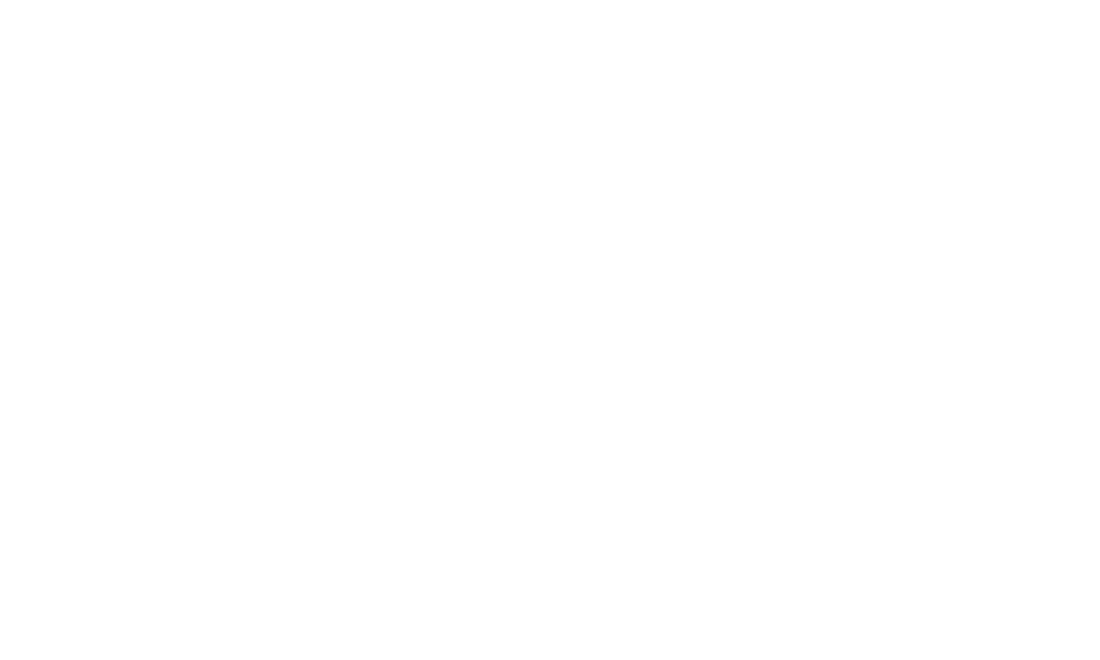

In [8]:
plt.close()
plt.subplots(figsize=(10,6))
ELMaly.plot_cmap_ELM(shot_data, ELM_itime, ELM_ftime)
plt.title(f"#{shot_data['number']}, time: {ELM_itime:.0f} [ms]", fontsize=17)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if savefigs: 
    path_filename = f"all_probes_ELM_FIGS/CMAP_{shot_data['number']}_time{ELM_itime:.0f}.png"
    plt.savefig(path_filename, dpi = 300);

# Processing Signal and Getting S points

In [9]:
 ###########################################################
lower_limit_point_of_analysis = 23    # Python index

"""
This parameter will remove the first N probes and the 
remaining ones will be used for the fit.
"""
###########################################################

probes_index = [f"0{i}" for i in range(1,10)] + list(range(10,55))
# Removing probes not receiving data
probes_index.remove(25)
probes_index.remove(26)

Te_processed = ELMaly.clean_ELM_signal(shot_data)
#plt.xlim([ELM_itime*0.997, ELM_itime*1.003])

ELM = Te_processed.sel(time=slice(ELM_itime, ELM_ftime))
time = ELM.time.data

# Reading Te per probe
Te_all_probes = np.zeros(( len(time),len(probes_index) ))
for j,pi in enumerate(probes_index):
    shot_data["probe_nr"] = pi
    Te_processed = ELMaly.clean_ELM_signal(shot_data)
    ELM = Te_processed.sel(time=slice(ELM_itime, ELM_ftime))    
    Te_all_probes[:,j] = ELM

# changing dtype of probes_index for plotting    
probes_index = np.array(probes_index).astype(int)

df_s_points = ELMaly.compute_s_points(shot_data, ELM_itime, ELM_ftime)
df_s_points = df_s_points.fillna(0)
df_s_points = df_s_points[~df_s_points.labels.isin([24,25])]

Te_max = pd.DataFrame(Te_all_probes).describe().loc["max"]

## Getting X points in terms of S

In [10]:
RZ_xpoint = shot[f"RZ_xpoint/EFIT:{shot_data['number']}"]
R_xpoint = RZ_xpoint.R_xpoint[:,0]; Z_xpoint = RZ_xpoint.Z_xpoint[:,0]
R_xpoint = R_xpoint.sel(time=slice(ELM_itime, ELM_ftime))

R_Xpoint_mean = np.mean(R_xpoint.data)*1e3 #[mm]

df_s_points["X_point_limits"] = df_s_points.R_mm > R_Xpoint_mean
low_limit_Xpoint_idx = df_s_points[~df_s_points.X_point_limits.isin([True])].index[-1]
upper_limit_Xpoint_idx = df_s_points[df_s_points.X_point_limits.isin([True])].index[0]
X_point_left_probe = df_s_points.loc[low_limit_Xpoint_idx]
X_point_right_probe = df_s_points.loc[upper_limit_Xpoint_idx]

delta_R_x_points = X_point_left_probe.R_mm - R_Xpoint_mean 
delta_R_probes   = X_point_left_probe.R_mm - X_point_right_probe.R_mm
delta_S_probes   = df_s_points.s_points[low_limit_Xpoint_idx] - df_s_points.s_points[upper_limit_Xpoint_idx]
S_left_probe     = df_s_points.s_points[low_limit_Xpoint_idx]

X_point_s_position = (delta_R_x_points/delta_R_probes)*delta_S_probes + S_left_probe

## FITTING

In [11]:
def eich_function(s, q0, S, s0, l):
    return q0/2 * np.exp( (S/(2*l))**2 + (s0-s)/l ) * erfc( S/(2*l) + (s0-s)/S ) # + qbg


def error_eich_function(s, popt, pcov):
    # Monte Carlo approach
    nber_sample = 10000
    
    #res = stats.multivariate_normal(mean = popt, cov = pcov).rvs(size = nber_sample)
    res = stats.multivariate_normal.rvs(mean = popt, cov = pcov, size = nber_sample)
    
    y_error = []
    s_max = []
    if np.size(s)>1:
        for n in s:
            y_error.append( np.std(eich_function(n, res[:,0], res[:,1], res[:,2], res[:,3])) )
            y_error_max =  np.argmax( eich_function(n, res[:,0], res[:,1], res[:,2], res[:,3]) )
            #s_max.append( n(y_error_max))
    else:
        y_error = np.std( eich_function(s, res[:,0], res[:,1], res[:,2], res[:,3]) )
        y_error_max = np.argmax( eich_function(s, res[:,0], res[:,1], res[:,2], res[:,3]) )
        #s_max = ( s(y_error_max))
    
    return np.asarray(y_error), np.asarray(y_error_max)#, np.asarray(s_max)

In [12]:
# For a single ELM

S = list(df_s_points.s_points.values)[lower_limit_point_of_analysis:]
Te = list(Te_max.values)[lower_limit_point_of_analysis:]

popt, pcov = curve_fit(eich_function, S, Te, bounds=([50., 2., -5, 5], [550., 10., +5, 100]))

x = list(range(-4000, 12000))
x = [n/100 for n in x]
x = np.asarray(x) # mm

eich = eich_function(x, popt[0], popt[1], popt[2], popt[3])
eich_max = np.nanmax(eich)

eich_error, y_error_max = error_eich_function(x, popt, pcov)

ind_eich_max = np.argmax(eich)
s_eich_max = x[ind_eich_max]

<IPython.core.display.Javascript object>


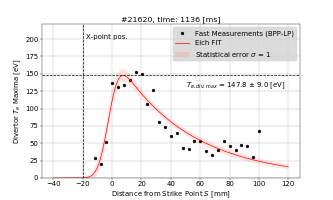

In [18]:
plt.close()

idx_max = np.argmax(eich)
time_std = 1

fig, ax = plt.subplots(1, figsize=(10,6))
plt.plot(S, Te, 'ko', label = 'Fast Measurements (BPP-LP)')
plt.plot(x, eich,'r-', label = 'Eich FIT')
ax.fill_between(
    x, eich + time_std*eich_error, eich - time_std*eich_error, 
    facecolor='salmon', 
    alpha=0.2, label = 'Statistical error $\sigma$ = ' + str(time_std)
)

Te_text = "$T_{e,div,max}$ = "+f"{eich[idx_max]:.1f} $\\pm$ {eich_error[idx_max]:.1f} [eV]"

plt.axhline(
    eich[idx_max], 
    c="k", linestyle="--"
)

x_point_text = "X-point pos."

plt.axvline(
    X_point_s_position, 
    c="k", linestyle="--"
)

plt.text(50,131,Te_text, fontsize=15)
plt.text(-18,200,x_point_text, fontsize=15)

plt.xlabel('Distance from Strike Point $S$ [mm]', fontsize = 15)
plt.ylabel('Divertor $T_e$ Maxima [eV]', fontsize = 15)
plt.ylim(0, eich_max*1.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title(f"#{shot_data['number']}, time: {ELM_itime:.0f} [ms]", fontsize=17)
plt.grid()
plt.legend(facecolor="lightgrey", fontsize=15)

if savefigs: 
    path_filename = f"Te_DIV_FIGS/DivTeMax_{shot_data['number']}_time{ELM_itime:.0f}_{lower_limit_point_of_analysis}.png"
    plt.savefig(path_filename, dpi = 300)

In [14]:
"""
TEMPERATURA MAXIMA
"""

eich[idx_max] # eV

147.79750956868256

In [15]:
"""
EROOR EN TEMPERATURA MAXIMA
"""

eich_error[idx_max] # eV

8.969302097742663

<IPython.core.display.Javascript object>


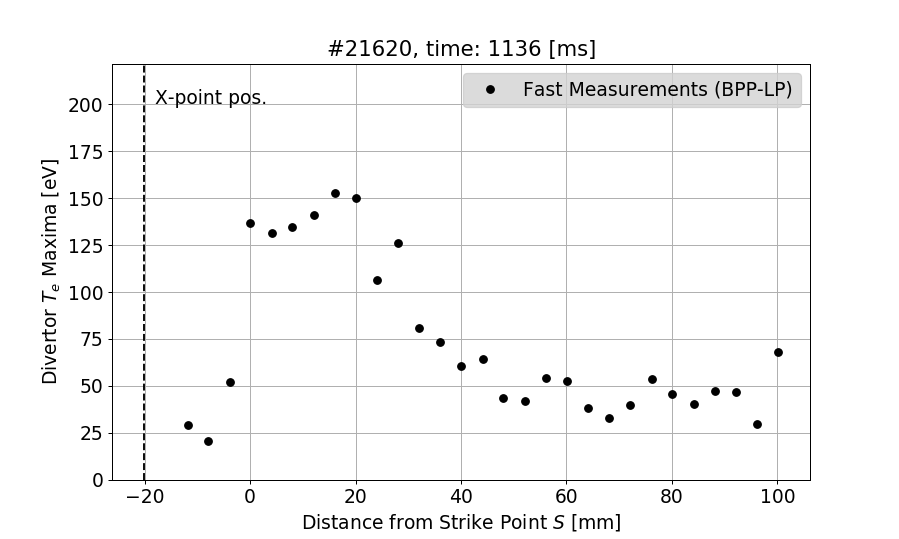

In [17]:
plt.close()

idx_max = np.argmax(eich)
time_std = 1

fig, ax = plt.subplots(1, figsize=(10,6))
plt.plot(S, Te, 'ko', label = 'Fast Measurements (BPP-LP)')

x_point_text = "X-point pos."

plt.axvline(
    X_point_s_position, 
    c="k", linestyle="--"
)

plt.text(-18,200,x_point_text, fontsize=15)

plt.xlabel('Distance from Strike Point $S$ [mm]', fontsize = 15)
plt.ylabel('Divertor $T_e$ Maxima [eV]', fontsize = 15)
plt.ylim(0, eich_max*1.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title(f"#{shot_data['number']}, time: {ELM_itime:.0f} [ms]", fontsize=17)
plt.grid()
plt.legend(facecolor="lightgrey", fontsize=15)

if savefigs: 
    path_filename = f"Te_DIV_FIGS/DivTeMax_{shot_data['number']}_time{ELM_itime:.0f}_{lower_limit_point_of_analysis}.png"
    plt.savefig(path_filename, dpi = 300)